# ISMB figures notebook

In [32]:

include("engines/init.jl")
include("engines/data_processing.jl")
include("engines/deep_learning.jl")
include("engines/cross_validation.jl")
outpath, session_id = set_dirs() ;

  Activating project at `~/vae_cox`


In [33]:
BRCA = MLSurvDataset("Data/TCGA_BRCA_tpm_n1049_btypes_labels_surv.h5")

MLSurvDataset(Float32[2.628389 0.60206 … 0.47712126 1.30103; 3.3195224 2.4843 … 0.90309 1.3617278; … ; 3.2151086 1.0413927 … 0.0 1.0791812; 3.328991 1.0 … 0.60206 1.5563025], ["001cef41-ff86-4d3f-a140-a647ac4b10a1", "0045349c-69d9-4306-a403-c9c1fa836644", "00807dae-9f4a-4fd1-aac2-82eb11bf2afb", "00a2d166-78c9-4687-a195-3d6315c27574", "00b11ca8-8540-4a3d-b602-ec754b00230b", "011b9b2d-ebe5-42bf-9662-d922faccc7a1", "01263518-5f7c-49dc-8d7e-84b0c03a6a63", "0130d616-885e-4a6c-9d03-2f17dd692a05", "01674b2c-5cf2-478f-84a1-f69c39f47bd4", "016caf42-4e19-4444-ab5d-6cf1e76c4afa"  …  "fb57c598-b45b-478a-9d34-ca1f050d5b7c", "fbee40f1-d6d8-4156-8d42-36e09bb9f095", "fc18d029-9be2-4fa0-9aef-6d647dc55f0b", "fcef8cb5-fb2c-4bfb-82cd-6b9f3145182c", "fd0b1b8b-1a76-480a-b61c-d176e4e02c6b", "fe15c48b-116d-461e-9b40-68514730fd18", "fe2cd610-aa52-4789-ac62-7683281bb22f", "fe7f74b8-20f4-4471-91dc-4cca8c68e5c0", "fec0da58-1047-44d2-b6d1-c18cceed43dc", "ff0f875f-113a-4c0f-8c0a-4259cd496e6d"], ["TSPAN6", "TNMD", "

In [2]:
LAML = MLSurvDataset("Data/LGN_AML_tpm_n300_btypes_labels_surv.h5") 

MLSurvDataset(Float32[0.008600163 0.0 … 0.0 0.0; 0.033423774 0.00432137 … 0.0 0.029383799; … ; 0.4828736 0.0 … 0.0 0.15836251; 0.045322984 0.017033324 … 0.0 0.20682588], ["01H001", "02H003", "02H009", "02H017", "02H026", "02H033", "02H053", "02H066", "03H016", "03H022"  …  "13H186", "14H001", "14H007", "14H012", "14H015", "14H017", "14H019", "14H020", "14H023", "14H038"], ["TSPAN6", "TNMD", "DPM1", "SCYL3", "C1orf112", "FGR", "CFH", "FUCA2", "GCLC", "NFYA"  …  "AP003086.3", "AL109627.1", "AC084851.4", "AC024558.2", "AC108479.4", "AL512357.2", "AL138899.3", "AL669830.1", "AC091135.2", "AL357075.5"], ["lncRNA", "lncRNA", "protein_coding", "lncRNA", "protein_coding", "lncRNA", "protein_coding,retained_intron", "lncRNA", "protein_coding", "protein_coding"  …  "transcribed_processed_pseudogene", "lncRNA", "processed_pseudogene", "protein_coding", "unprocessed_pseudogene", "lncRNA", "protein_coding", "retained_intron", "unprocessed_pseudogene", "protein_coding"], ["Therapy-related myeloid ne

In [3]:
function format_train_test(fold; device = gpu)
    nsamples = size(fold["train_x"])[1]
    ordering = sortperm(-fold["Y_t_train"])
    train_x = device(Matrix(fold["train_x"][ordering,:]'));
    train_y_t = device(Matrix(fold["Y_t_train"][ordering,:]'));
    train_y_e = device(Matrix(fold["Y_e_train"][ordering,:]'));
    NE_frac_tr = sum(train_y_e .== 1) != 0 ? 1 / sum(train_y_e .== 1) : 0

    nsamples = size(fold["test_x"])[1]
    ordering = sortperm(-fold["Y_t_test"])
    test_x = device(Matrix(fold["test_x"][ordering,:]'));
    test_y_t = device(Matrix(fold["Y_t_test"][ordering,:]'));
    test_y_e = device(Matrix(fold["Y_e_test"][ordering,:]'));
    NE_frac_tst = sum(test_y_e .== 1) != 0 ? 1 / sum(test_y_e .== 1) : 0
    return train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst
end 

format_train_test (generic function with 1 method)

In [4]:

function data_prep(DATA;nfolds = 5, nepochs =1000, dim_redux= 125)
    keep = [occursin("protein_coding", bt) for bt in DATA.biotypes]
    println("nb genes : $(sum(keep))")
    println("nb patients : $(size(DATA.samples)[1])")
    println("% uncensored : $(mean(DATA.surve .!= 0))")
    params_dict = Dict(
            ## run infos 
            "session_id" => session_id, "nfolds" =>5,  "modelid" => "$(bytes2hex(sha256("$(now())"))[1:Int(floor(end/3))])",
            "machine_id"=>strip(read(`hostname`, String)), "device" => "$(device())", "model_title"=>"AECPHDNN",
            ## data infos 
            "dataset" => "BRCA_data(norm=true)", "nsamples" => size(DATA.samples)[1],
            "nsamples_test" => Int(round(size(DATA.samples)[1] / nfolds)), "ngenes" => size(DATA.genes[keep])[1],
            "nsamples_train" => size(DATA.samples)[1] - Int(round(size(DATA.samples)[1] / nfolds)),
            ## optim infos 
            "nepochs" => nepochs, "ae_lr" =>1e-6, "cph_lr" => 1e-5, "ae_wd" => 1e-6, "cph_wd" => 1e-6,
            ## model infos
            "model_type"=> "vaecox", "dim_redux" => dim_redux, "ae_nb_hls" => 2,
            "enc_nb_hl" => 2, "enc_hl_size"=> 128,
            "venc_nb_hl" => 2, "venc_hl_size"=> 128,  "dec_nb_hl" => 2 , "dec_hl_size"=> 128,
            "nb_clinf" => 0, "cph_nb_hl" => 2, "cph_hl_size" => 64, 
            "insize" => size(DATA.genes[keep])[1],
            ## metrics
            "model_cv_complete" => false
        )
    # split train test
    folds = split_train_test(Matrix(DATA.data[:,keep]), DATA.survt, DATA.surve, DATA.samples;nfolds =5)
    fold = folds[1]
    # format input data  
    train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst = format_train_test(fold)

    return train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst, params_dict
end



data_prep (generic function with 1 method)

In [5]:
function cox_nll_vec(mdl::Chain, X_, Y_e_, NE_frac)
    outs = vec(mdl(X_))
    #outs = vec(mdl.cphdnn(mdl.encoder(X_)))
    hazard_ratios = exp.(outs)
    log_risk = log.(cumsum(hazard_ratios))
    uncensored_likelihood = outs .- log_risk
    censored_likelihood = uncensored_likelihood .* Y_e_'
    #neg_likelihood = - sum(censored_likelihood) / sum(e .== 1)
    neg_likelihood = - sum(censored_likelihood) * NE_frac
    return neg_likelihood
end 

cox_nll_vec (generic function with 6 methods)

In [6]:
function VAE_COX_loss(VENC::VariationalEncoder, CPH, X, Y_e, NE_frac;device = gpu)
    mu, log_sigma = VENC(X)
    #z = mu + device(randn(Float32, size(log_sigma))) .* exp.(log_sigma)
    outs = vec(CPH(mu))
    hazard_ratios = exp.(outs)
    log_risk = log.(cumsum(hazard_ratios))
    uncensored_likelihood = outs .- log_risk
    censored_likelihood = uncensored_likelihood .* Y_e'
    #neg_likelihood = - sum(censored_likelihood) / sum(e .== 1)
    neg_likelihood = - sum(censored_likelihood) * NE_frac
    return neg_likelihood
end 

VAE_COX_loss (generic function with 1 method)

In [7]:
function VariationalEncoder(input_dim::Int, latent_dim::Int, hidden_dim::Int;device = gpu) 
    return VariationalEncoder(
    device(Chain(Dense(input_dim, hidden_dim, leakyrelu), Dense(hidden_dim,hidden_dim, leakyrelu))),   # linear
    device(Dense(hidden_dim, latent_dim)),        # mu
    device(Dense(hidden_dim, latent_dim)))        # log sigma
end 

VariationalEncoder

In [8]:
function l2_penalty(model::VariationalEncoder)
    l2_sum = 0
    for wm in model.linear
        l2_sum += sum(abs2, wm.weight)
    end 
    l2_sum += sum(abs2, model.mu.weight)
    l2_sum += sum(abs2, model.log_sigma.weight)
    return l2_sum
end

l2_penalty (generic function with 7 methods)

In [16]:
train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst, params_dict = data_prep(BRCA;nepochs = 10_000, dim_redux = 300)
venc = VariationalEncoder(size(train_x)[1], params_dict["dim_redux"], 600)
vdec = Decoder(size(train_x)[1], params_dict["dim_redux"], 600)
cphdnn = gpu(Chain(Dense(params_dict["dim_redux"],512, leakyrelu), Dense(512,512, leakyrelu), Dense(512, 1, bias = false)))
opt1 = Flux.ADAM(1e-6) ## opt VENC-CPHDNN
opt2 = Flux.ADAM(1e-5) ## opt VAE
wd = params_dict["cph_wd"]
opt = Flux.ADAM(params_dict["cph_lr"])
# training VAE only first
for i in 1:3000
    vaecox_loss =  round(VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd + l2_penalty(venc) * wd, digits = 3)  
    
    OUTS_tr = cphdnn(venc(train_x)[1])
    OUTS_tst = cphdnn(venc(test_x)[1])
    
    ps2 = Flux.params(venc, vdec)
    gs2 = gradient(ps2) do 
        VAE_lossf(venc, vdec, train_x) + l2_penalty(venc) * wd + l2_penalty(vdec) * wd
        #VAE_COX_loss(model["venc"], model["cph"], train_x, train_y_e, NE_frac_tr) + l2_penalty(model["venc"]) * wd + l2_penalty(model["cph"]) * wd 
    end 
    vae_loss =  round(VAE_lossf(venc, vdec, train_x) + l2_penalty(venc) * wd + l2_penalty(vdec) * wd, digits = 3)  
    VAE_test = round(my_cor(vec(test_x), vec(MyReconstruct(venc, vdec, test_x)[end])),digits = 3)

    cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, -1 * OUTS_tr)
    cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e, -1 *OUTS_tst)
    
    if i%400 ==0 || i == 1
    println("$i TRAIN $vaecox_loss cind: $(round(cind_tr, digits = 3)) \t TEST ae-corr: $VAE_test \tcind: $(round(cind_test, digits = 3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")
    end 
    #Flux.update!(opt1,ps1, gs1)
    Flux.update!(opt2,ps2, gs2)
    params_dict["cph_tst_c_ind"] = cind_test
    params_dict["cph_train_c_ind"] = cind_tr
    params_dict["step"] = i 
end
# training VENC-CPHDNN 
for i in 1:params_dict["nepochs"]
    ps1 = Flux.params(cphdnn)
    gs1 = gradient(ps1) do 
        cox_nll_vec(cphdnn, venc(train_x)[1], train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd 
        #VAE_COX_loss(model["venc"], model["cph"], train_x, train_y_e, NE_frac_tr) + l2_penalty(model["venc"]) * wd + l2_penalty(model["cph"]) * wd 
    end 
    vaecox_loss =  round(cox_nll_vec(cphdnn, venc(train_x)[1], train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd  , digits = 3)  
    OUTS_tr = cphdnn(venc(train_x)[1])
    OUTS_tst = cphdnn(venc(test_x)[1])
    
    vae_loss =  round(VAE_lossf(venc, vdec, train_x) + l2_penalty(venc) * wd + l2_penalty(vdec) * wd, digits = 3)  
    VAE_test = round(my_cor(vec(test_x), vec(MyReconstruct(venc, vdec, test_x)[end])),digits = 3)

    cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, -1 * OUTS_tr)
    cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e, -1 *OUTS_tst)
    
    if i%400 ==0 || i == 1
    println("$i TRAIN $vaecox_loss cind: $(round(cind_tr, digits = 3)) \t TEST ae-corr: $VAE_test \tcind: $(round(cind_test, digits = 3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")
    end 
    Flux.update!(opt1,ps1, gs1)
    #Flux.update!(opt2,ps2, gs2)
    params_dict["cph_tst_c_ind"] = cind_test
    params_dict["cph_train_c_ind"] = cind_tr
    params_dict["step"] = i 
end
# training VENC-CPHDNN 
for i in 1:params_dict["nepochs"]
    ps1 = Flux.params(venc, cphdnn)
    gs1 = gradient(ps1) do 
        VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd + l2_penalty(venc) * wd
        #VAE_COX_loss(model["venc"], model["cph"], train_x, train_y_e, NE_frac_tr) + l2_penalty(model["venc"]) * wd + l2_penalty(model["cph"]) * wd 
    end 
    vaecox_loss =  round(VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd + l2_penalty(venc) * wd, digits = 3)  
    OUTS_tr = cphdnn(venc(train_x)[1])
    OUTS_tst = cphdnn(venc(test_x)[1])
    
    vae_loss =  round(VAE_lossf(venc, vdec, train_x) + l2_penalty(venc) * wd + l2_penalty(vdec) * wd, digits = 3)  
    VAE_test = round(my_cor(vec(test_x), vec(MyReconstruct(venc, vdec, test_x)[end])),digits = 3)

    cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, -1 * OUTS_tr)
    cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e, -1 *OUTS_tst)
    
    if i%400 ==0 || i == 1
    println("$i TRAIN $vaecox_loss cind: $(round(cind_tr, digits = 3)) \t TEST ae-corr: $VAE_test \tcind: $(round(cind_test, digits = 3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")
    end 
    Flux.update!(opt1,ps1, gs1)
    #Flux.update!(opt2,ps2, gs2)
    params_dict["cph_tst_c_ind"] = cind_test
    params_dict["cph_train_c_ind"] = cind_tr
    params_dict["step"] = i 
end

nb genes : 19962
nb patients : 1049
% uncensored : 0.14013346043851288


1 TRAIN 5.461 cind: 0.469 	 TEST ae-corr: -0.003 	cind: 0.468 [1082, 1229, 0]


400 TRAIN 5.461 cind: 0.469 	 TEST ae-corr: 0.651 	cind: 0.468 [1082, 1229, 0]


800 TRAIN 5.461 cind: 0.469 	 TEST ae-corr: 0.808 	cind: 0.468 [1082, 1229, 0]


1200 TRAIN 5.461 cind: 0.469 	 TEST ae-corr: 0.852 	cind: 0.468 [1082, 1229, 0]


1600 TRAIN 5.461 cind: 0.469 	 TEST ae-corr: 0.888 	cind: 0.468 [1082, 1229, 0]


2000 TRAIN 5.461 cind: 0.469 	 TEST ae-corr: 0.9 	cind: 0.468 [1082, 1229, 0]


2400 TRAIN 5.461 cind: 0.469 	 TEST ae-corr: 0.916 	cind: 0.468 [1082, 1229, 0]


2800 TRAIN 5.461 cind: 0.469 	 TEST ae-corr: 0.926 	cind: 0.468 [1082, 1229, 0]


1 TRAIN 5.459 cind: 0.469 	 TEST ae-corr: 0.927 	cind: 0.468 [1082, 1229, 0]


400 TRAIN 5.372 cind: 0.622 	 TEST ae-corr: 0.928 	cind: 0.486 [1122, 1189, 0]


800 TRAIN 5.32 cind: 0.677 	 TEST ae-corr: 0.929 	cind: 0.497 [1148, 1163, 0]


1200 TRAIN 5.274 cind: 0.714 	 TEST ae-corr: 0.929 	cind: 0.511 [1182, 1129, 0]


1600 TRAIN 5.231 cind: 0.742 	 TEST ae-corr: 0.931 	cind: 0.524 [1210, 1101, 0]


2000 TRAIN 5.188 cind: 0.764 	 TEST ae-corr: 0.93 	cind: 0.536 [1238, 1073, 0]


2400 TRAIN 5.144 cind: 0.778 	 TEST ae-corr: 0.928 	cind: 0.537 [1242, 1069, 0]


2800 TRAIN 5.1 cind: 0.792 	 TEST ae-corr: 0.929 	cind: 0.543 [1256, 1055, 0]


3200 TRAIN 5.055 cind: 0.804 	 TEST ae-corr: 0.929 	cind: 0.549 [1269, 1042, 0]


3600 TRAIN 5.01 cind: 0.813 	 TEST ae-corr: 0.929 	cind: 0.553 [1278, 1033, 0]


4000 TRAIN 4.957 cind: 0.822 	 TEST ae-corr: 0.929 	cind: 0.553 [1279, 1032, 0]


4400 TRAIN 4.911 cind: 0.83 	 TEST ae-corr: 0.93 	cind: 0.557 [1287, 1024, 0]


4800 TRAIN 4.865 cind: 0.838 	 TEST ae-corr: 0.927 	cind: 0.558 [1290, 1021, 0]


5200 TRAIN 4.818 cind: 0.844 	 TEST ae-corr: 0.928 	cind: 0.56 [1295, 1016, 0]


5600 TRAIN 4.771 cind: 0.85 	 TEST ae-corr: 0.928 	cind: 0.562 [1299, 1012, 0]


6000 TRAIN 4.725 cind: 0.855 	 TEST ae-corr: 0.93 	cind: 0.563 [1302, 1009, 0]


6400 TRAIN 4.679 cind: 0.861 	 TEST ae-corr: 0.929 	cind: 0.565 [1305, 1006, 0]


6800 TRAIN 4.634 cind: 0.866 	 TEST ae-corr: 0.929 	cind: 0.562 [1299, 1012, 0]


7200 TRAIN 4.587 cind: 0.871 	 TEST ae-corr: 0.93 	cind: 0.56 [1295, 1016, 0]


7600 TRAIN 4.544 cind: 0.876 	 TEST ae-corr: 0.93 	cind: 0.561 [1297, 1014, 0]


8000 TRAIN 4.501 cind: 0.881 	 TEST ae-corr: 0.929 	cind: 0.558 [1290, 1021, 0]


8400 TRAIN 4.46 cind: 0.885 	 TEST ae-corr: 0.927 	cind: 0.559 [1293, 1018, 0]


8800 TRAIN 4.419 cind: 0.89 	 TEST ae-corr: 0.928 	cind: 0.56 [1295, 1016, 0]


9200 TRAIN 4.377 cind: 0.894 	 TEST ae-corr: 0.93 	cind: 0.559 [1292, 1019, 0]


9600 TRAIN 4.335 cind: 0.898 	 TEST ae-corr: 0.93 	cind: 0.559 [1291, 1020, 0]


10000 TRAIN 4.292 cind: 0.903 	 TEST ae-corr: 0.929 	cind: 0.559 [1292, 1019, 0]


1 TRAIN 4.294 cind: 0.903 	 TEST ae-corr: 0.929 	cind: 0.559 [1292, 1019, 0]


400 TRAIN 4.254 cind: 0.907 	 TEST ae-corr: 0.928 	cind: 0.556 [1286, 1025, 0]


800 TRAIN 4.213 cind: 0.912 	 TEST ae-corr: 0.928 	cind: 0.558 [1290, 1021, 0]


1200 TRAIN 4.172 cind: 0.915 	 TEST ae-corr: 0.928 	cind: 0.557 [1288, 1023, 0]


1600 TRAIN 4.129 cind: 0.918 	 TEST ae-corr: 0.929 	cind: 0.559 [1291, 1020, 0]


2000 TRAIN 4.089 cind: 0.922 	 TEST ae-corr: 0.93 	cind: 0.557 [1287, 1024, 0]


2400 TRAIN 4.049 cind: 0.925 	 TEST ae-corr: 0.929 	cind: 0.556 [1285, 1026, 0]


2800 TRAIN 4.01 cind: 0.928 	 TEST ae-corr: 0.929 	cind: 0.555 [1283, 1028, 0]


3200 TRAIN 3.969 cind: 0.93 	 TEST ae-corr: 0.929 	cind: 0.555 [1282, 1029, 0]


3600 TRAIN 3.929 cind: 0.933 	 TEST ae-corr: 0.929 	cind: 0.553 [1278, 1033, 0]


4000 TRAIN 3.886 cind: 0.936 	 TEST ae-corr: 0.928 	cind: 0.553 [1279, 1032, 0]


4400 TRAIN 3.845 cind: 0.938 	 TEST ae-corr: 0.929 	cind: 0.555 [1282, 1029, 0]


4800 TRAIN 3.804 cind: 0.941 	 TEST ae-corr: 0.929 	cind: 0.553 [1279, 1032, 0]


5200 TRAIN 3.761 cind: 0.943 	 TEST ae-corr: 0.929 	cind: 0.556 [1284, 1027, 0]


5600 TRAIN 3.719 cind: 0.946 	 TEST ae-corr: 0.93 	cind: 0.557 [1288, 1023, 0]


6000 TRAIN 3.675 cind: 0.948 	 TEST ae-corr: 0.928 	cind: 0.56 [1294, 1017, 0]


6400 TRAIN 3.632 cind: 0.951 	 TEST ae-corr: 0.929 	cind: 0.56 [1294, 1017, 0]


6800 TRAIN 3.594 cind: 0.953 	 TEST ae-corr: 0.929 	cind: 0.559 [1293, 1018, 0]


7200 TRAIN 3.555 cind: 0.955 	 TEST ae-corr: 0.927 	cind: 0.559 [1292, 1019, 0]


7600 TRAIN 3.518 cind: 0.957 	 TEST ae-corr: 0.929 	cind: 0.56 [1294, 1017, 0]


8000 TRAIN 3.478 cind: 0.959 	 TEST ae-corr: 0.928 	cind: 0.561 [1296, 1015, 0]


8400 TRAIN 3.44 cind: 0.961 	 TEST ae-corr: 0.928 	cind: 0.563 [1302, 1009, 0]


8800 TRAIN 3.402 cind: 0.963 	 TEST ae-corr: 0.929 	cind: 0.563 [1301, 1010, 0]


9200 TRAIN 3.364 cind: 0.965 	 TEST ae-corr: 0.929 	cind: 0.566 [1307, 1004, 0]


9600 TRAIN 3.327 cind: 0.967 	 TEST ae-corr: 0.928 	cind: 0.569 [1314, 997, 0]


10000 TRAIN 3.287 cind: 0.969 	 TEST ae-corr: 0.931 	cind: 0.571 [1319, 992, 0]


In [34]:
train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst, params_dict = data_prep(BRCA;nepochs = 10_000, dim_redux = 300)
venc = VariationalEncoder(size(train_x)[1], params_dict["dim_redux"], 600)
vdec = Decoder(size(train_x)[1], params_dict["dim_redux"], 600)
cphdnn = gpu(Chain(Dense(params_dict["dim_redux"],512, leakyrelu), Dense(512,512, leakyrelu), Dense(512, 1, bias = false)))
opt1 = Flux.ADAM(1e-6) ## opt VENC-CPHDNN
opt2 = Flux.ADAM(1e-5) ## opt VAE
wd = params_dict["cph_wd"]
opt = Flux.ADAM(params_dict["cph_lr"])
for i in 1:params_dict["nepochs"]
    ps1 = Flux.params(venc, cphdnn)
    gs1 = gradient(ps1) do 
        VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd + l2_penalty(venc) * wd
        #VAE_COX_loss(model["venc"], model["cph"], train_x, train_y_e, NE_frac_tr) + l2_penalty(model["venc"]) * wd + l2_penalty(model["cph"]) * wd 
    end 
    vaecox_loss =  round(VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr) + l2_penalty(cphdnn) * wd + l2_penalty(venc) * wd, digits = 3)  
    OUTS_tr = cphdnn(venc(train_x)[1])
    OUTS_tst = cphdnn(venc(test_x)[1])
    
    vae_loss =  round(VAE_lossf(venc, vdec, train_x) + l2_penalty(venc) * wd + l2_penalty(vdec) * wd, digits = 3)  
    VAE_test = round(my_cor(vec(test_x), vec(MyReconstruct(venc, vdec, test_x)[end])),digits = 3)

    cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, -1 * OUTS_tr)
    cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e, -1 *OUTS_tst)
    
    if i%400 ==0 || i == 1
    println("$i TRAIN $vaecox_loss cind: $(round(cind_tr, digits = 3)) \t TEST ae-corr: $VAE_test \tcind: $(round(cind_test, digits = 3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")
    end 
    Flux.update!(opt1,ps1, gs1)
    #Flux.update!(opt2,ps2, gs2)
    params_dict["cph_tst_c_ind"] = cind_test
    params_dict["cph_train_c_ind"] = cind_tr
    params_dict["step"] = i 
end

nb genes : 19962
nb patients : 1049
% uncensored : 0.14013346043851288


1 TRAIN 5.52 cind: 0.521 	 TEST ae-corr: -0.002 	cind: 0.476 [1215, 1337, 0]


400 TRAIN 5.377 cind: 0.647 	 TEST ae-corr: -0.002 	cind: 0.548 [1399, 1153, 0]


800 TRAIN 5.281 cind: 0.729 	 TEST ae-corr: -0.002 	cind: 0.593 [1513, 1039, 0]


1200 TRAIN 5.198 cind: 0.77 	 TEST ae-corr: -0.002 	cind: 0.611 [1560, 992, 0]


1600 TRAIN 5.12 cind: 0.795 	 TEST ae-corr: -0.002 	cind: 0.624 [1593, 959, 0]


2000 TRAIN 5.047 cind: 0.812 	 TEST ae-corr: -0.002 	cind: 0.633 [1616, 936, 0]


2400 TRAIN 4.972 cind: 0.826 	 TEST ae-corr: -0.002 	cind: 0.639 [1631, 921, 0]


2800 TRAIN 4.901 cind: 0.838 	 TEST ae-corr: -0.002 	cind: 0.644 [1644, 908, 0]


3200 TRAIN 4.829 cind: 0.847 	 TEST ae-corr: -0.002 	cind: 0.651 [1661, 891, 0]


3600 TRAIN 4.759 cind: 0.857 	 TEST ae-corr: -0.003 	cind: 0.654 [1668, 884, 0]


4000 TRAIN 4.688 cind: 0.866 	 TEST ae-corr: -0.002 	cind: 0.659 [1683, 869, 0]


4400 TRAIN 4.621 cind: 0.874 	 TEST ae-corr: -0.002 	cind: 0.663 [1691, 861, 0]


4800 TRAIN 4.551 cind: 0.882 	 TEST ae-corr: -0.002 	cind: 0.668 [1704, 848, 0]


5200 TRAIN 4.485 cind: 0.889 	 TEST ae-corr: -0.002 	cind: 0.67 [1711, 841, 0]


5600 TRAIN 4.42 cind: 0.896 	 TEST ae-corr: -0.002 	cind: 0.671 [1712, 840, 0]


6000 TRAIN 4.357 cind: 0.902 	 TEST ae-corr: -0.002 	cind: 0.671 [1712, 840, 0]


6400 TRAIN 4.293 cind: 0.907 	 TEST ae-corr: -0.002 	cind: 0.678 [1730, 822, 0]


6800 TRAIN 4.232 cind: 0.912 	 TEST ae-corr: -0.002 	cind: 0.678 [1729, 823, 0]


7200 TRAIN 4.172 cind: 0.918 	 TEST ae-corr: -0.002 	cind: 0.681 [1738, 814, 0]


7600 TRAIN 4.111 cind: 0.922 	 TEST ae-corr: -0.002 	cind: 0.684 [1746, 806, 0]


8000 TRAIN 4.052 cind: 0.926 	 TEST ae-corr: -0.002 	cind: 0.688 [1757, 795, 0]


8400 TRAIN 3.993 cind: 0.93 	 TEST ae-corr: -0.002 	cind: 0.689 [1759, 793, 0]


8800 TRAIN 3.932 cind: 0.935 	 TEST ae-corr: -0.002 	cind: 0.688 [1755, 797, 0]


9200 TRAIN 3.872 cind: 0.939 	 TEST ae-corr: -0.002 	cind: 0.689 [1758, 794, 0]


9600 TRAIN 3.813 cind: 0.943 	 TEST ae-corr: -0.002 	cind: 0.69 [1761, 791, 0]


10000 TRAIN 3.755 cind: 0.946 	 TEST ae-corr: -0.002 	cind: 0.693 [1769, 783, 0]


In [ ]:
function validate_vaecox(DATA, params_dict;device = gpu)
    nfolds, nepochs, dim_redux = 5, 1000, 125
    keep = [occursin("protein_coding", bt) for bt in DATA.biotypes]
    # split train test
    folds = split_train_test(Matrix(DATA.data[:,keep]), DATA.survt, DATA.surve, DATA.samples;nfolds =5)
    fold = folds[1]

    venc = VariationalEncoder(size(DATA.data[:,keep])[2], 125, 600)
    vdec = Decoder(size(DATA.data[:,keep])[2], 125, 600)
    VAE_opt = Flux.ADAM(1e-4)

    cphdnn = device(Chain(Dense(size(DATA.data[:,keep])[2], 125, leakyrelu), Dense(125, 100,leakyrelu),Dense(100, 1)))
    cphdnn_opt = Flux.ADAM(1e-5)

    train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst = format_train_test(fold)
    for i in 1:nepochs
        ps1 = Flux.params(venc, vdec)
        gs1 = gradient(ps1) do
            VAE_lossf(venc, vdec, train_x)
        end 
        VAE_loss = VAE_lossf(venc, vdec, train_x)
        VAE_cor = round(my_cor(vec(train_x), vec(MyReconstruct(venc, vdec, train_x)[end])),digits = 3)
        VAE_test = round(my_cor(vec(test_x), vec(MyReconstruct(venc, vdec, test_x)[end])),digits = 3)

        ps2 = Flux.params(venc, cphdnn)
        gs2 = gradient(ps2) do 
            cox_nll_vec(cphdnn, train_x, train_y_e, NE_frac_tr)
            #VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr)
        end 
        CPH_loss = round(cox_nll_vec(cphdnn, train_x, train_y_e, NE_frac_tr), digits = 3) #round(VAE_COX_loss(venc, cphdnn, train_x, train_y_e, NE_frac_tr), digits = 3)
        #mu, log_sigma = venc(train_x)
        #z = mu + device(randn(Float32, size(log_sigma))) .* exp.(log_sigma)
        #OUTS_tr = vec(cphdnn(z))
        OUTS_tr = cphdnn(train_x)
        OUTS_tst =  cphdnn(test_x)
        cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, OUTS_tr)
        cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e,OUTS_tst)
        #Flux.update!(VAE_opt, ps1, gs1)
        Flux.update!(cphdnn_opt, ps2, gs2)
        if i % 100 == 0 || i == 1
            println("$i TRAIN - VAE-loss-avg: $VAE_loss\tVAE-cor: $VAE_cor CPH-loss: $CPH_loss CPH-cind: $(round(cind_tr,digits=3))")
            println("$i TEST - VAE-loss-avg: $VAE_test \tVAE-cor: CPH-loss: CPH-cind: $(round(cind_test,digits=3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")

        end
    end
    return cphdnn
end 

In [ ]:
cdnn = validate_vaecox(DATA, params_dict)

In [ ]:
cdnn(DATA.data[])

In [96]:
train_x, train_y_t, train_y_e, NE_frac_tr, test_x, test_y_t, test_y_e, NE_frac_tst, params_dict = data_prep(LAML)
# create model 
model = build_aecox(params_dict)
for iter in 1:params_dict["nepochs"]
    ps1 = Flux.params(model["cph"].model, model["enc"])
    gs1 = gradient(ps1) do
        model["cph"].lossf(model["cph"],model["enc"], train_x, train_y_e, NE_frac_tr, params_dict["cph_wd"])
    end 
    ## gradient Auto-Encoder 
    ps2 = Flux.params(model["ae"].net)
    gs2 = gradient(ps2) do
        model["ae"].lossf(model["ae"], train_x, train_x, weight_decay = params_dict["ae_wd"])
    end
    Flux.update!(model["cph"].opt, ps1, gs1)
    #Flux.update!(model["ae"].opt, ps2, gs2)

    ######
    OUTS_tr = vec(model["cph"].model(model["enc"](train_x)))
    ae_loss = model["ae"].lossf(model["ae"], train_x, train_x, weight_decay = params_dict["ae_wd"])
    ae_cor =  round(my_cor(vec(train_x), vec(model["ae"].net(train_x))),digits = 3)
    cph_loss = model["cph"].lossf(model["cph"],model["enc"](train_x), train_y_e, NE_frac_tr, params_dict["cph_wd"])
    ae_loss_test = round(model["ae"].lossf(model["ae"], test_x, test_x, weight_decay = params_dict["ae_wd"]), digits = 3)
    ae_cor_test = round(my_cor(vec(test_x), vec(model["ae"].net(test_x))), digits= 3)
    cph_loss_test = round(model["cph"].lossf(model["cph"],model["enc"](test_x), test_y_e, NE_frac_tst, params_dict["cph_wd"]), digits= 3)
                    
    OUTS_tst =  vec(model["cph"].model(model["enc"](test_x)))
            
    cind_tr, cdnt_tr, ddnt_tr, tied_tr  = concordance_index(train_y_t, train_y_e, OUTS_tr)
    cind_test,cdnt_tst, ddnt_tst, tied_tst = concordance_index(test_y_t, test_y_e,OUTS_tst)
    if iter % 100 == 0  || iter == 1     
        println("FOLD $iter\t TRAIN AE-loss $(round(ae_loss,digits =3)) \t AE-cor: $(round(ae_cor, digits = 3))\t cph-loss-avg: $(round(cph_loss / params_dict["nsamples_train"],digits =6)) \t cph-cind: $(round(cind_tr,digits =3))")
        println("\t\tTEST AE-loss $(round(ae_loss_test,digits =3)) \t AE-cor: $(round(ae_cor_test, digits = 3))\t cph-loss-avg: $(round(cph_loss_test / params_dict["nsamples_test"],digits =6)) \t cph-cind: $(round(cind_test,digits =3)) [$(Int(cdnt_tst)), $(Int(ddnt_tst)), $(Int(tied_tst))]")
    end
    params_dict["cph_tst_c_ind"] = concordance_index(test_y_t, test_y_e, OUTS_tst)[1]
    params_dict["cph_train_c_ind"] = concordance_index(train_y_t, train_y_e, OUTS_tr)[1]
    params_dict["step"] = iter 
end


nb genes : 14996
nb patients : 300
% uncensored : 0.7433333333333333


FOLD 1	 TRAIN AE-loss 0.994 	 AE-cor: 0.008	 cph-loss-avg: 0.020545 	 cph-cind: 0.611
		TEST AE-loss 0.991 	 AE-cor: 0.006	 cph-loss-avg: 0.058383 	 cph-cind: 0.515 [836, 788, 0]


FOLD 100	 TRAIN AE-loss 0.972 	 AE-cor: 0.004	 cph-loss-avg: 0.019126 	 cph-cind: 0.827
		TEST AE-loss 0.97 	 AE-cor: 0.002	 cph-loss-avg: 0.0563 	 cph-cind: 0.657 [1067, 557, 0]


FOLD 200	 TRAIN AE-loss 0.969 	 AE-cor: 0.004	 cph-loss-avg: 0.018949 	 cph-cind: 0.863
		TEST AE-loss 0.967 	 AE-cor: 0.002	 cph-loss-avg: 0.056367 	 cph-cind: 0.646 [1049, 575, 0]


FOLD 300	 TRAIN AE-loss 0.966 	 AE-cor: 0.004	 cph-loss-avg: 0.018913 	 cph-cind: 0.875
		TEST AE-loss 0.965 	 AE-cor: 0.002	 cph-loss-avg: 0.0564 	 cph-cind: 0.643 [1045, 579, 0]


FOLD 400	 TRAIN AE-loss 0.964 	 AE-cor: 0.004	 cph-loss-avg: 0.018904 	 cph-cind: 0.881
		TEST AE-loss 0.963 	 AE-cor: 0.002	 cph-loss-avg: 0.056483 	 cph-cind: 0.638 [1036, 588, 0]


FOLD 500	 TRAIN AE-loss 0.963 	 AE-cor: 0.005	 cph-loss-avg: 0.018899 	 cph-cind: 0.883
		TEST AE-loss 0.962 	 AE-cor: 0.003	 cph-loss-avg: 0.05645 	 cph-cind: 0.638 [1036, 588, 0]


FOLD 600	 TRAIN AE-loss 0.962 	 AE-cor: 0.005	 cph-loss-avg: 0.018898 	 cph-cind: 0.884
		TEST AE-loss 0.961 	 AE-cor: 0.003	 cph-loss-avg: 0.056433 	 cph-cind: 0.639 [1037, 587, 0]


FOLD 700	 TRAIN AE-loss 0.962 	 AE-cor: 0.005	 cph-loss-avg: 0.018897 	 cph-cind: 0.886
		TEST AE-loss 0.96 	 AE-cor: 0.004	 cph-loss-avg: 0.056417 	 cph-cind: 0.638 [1036, 588, 0]


FOLD 800	 TRAIN AE-loss 0.962 	 AE-cor: 0.005	 cph-loss-avg: 0.018899 	 cph-cind: 0.887
		TEST AE-loss 0.96 	 AE-cor: 0.004	 cph-loss-avg: 0.056417 	 cph-cind: 0.641 [1041, 583, 0]


FOLD 900	 TRAIN AE-loss 0.961 	 AE-cor: 0.005	 cph-loss-avg: 0.018896 	 cph-cind: 0.889
		TEST AE-loss 0.96 	 AE-cor: 0.004	 cph-loss-avg: 0.0564 	 cph-cind: 0.64 [1039, 585, 0]


FOLD 1000	 TRAIN AE-loss 0.961 	 AE-cor: 0.005	 cph-loss-avg: 0.018893 	 cph-cind: 0.892
		TEST AE-loss 0.96 	 AE-cor: 0.004	 cph-loss-avg: 0.0564 	 cph-cind: 0.64 [1040, 584, 0]


In [140]:
model = build_aecox(params_dict)
model["ae"]

AE_model(Chain(Dense(14996 => 3040, leakyrelu), Dense(3040 => 616, leakyrelu), Dense(616 => 125), Dense(125 => 616, leakyrelu), Dense(616 => 3040, leakyrelu), Dense(3040 => 14996, leakyrelu)), Chain(Dense(14996 => 3040, leakyrelu), Dense(3040 => 616, leakyrelu), Dense(616 => 125)), Chain(Dense(125 => 616, leakyrelu), Dense(616 => 3040, leakyrelu), Dense(3040 => 14996, leakyrelu)), Dense(3040 => 14996, leakyrelu), Adam(1.0e-6, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}()), mse_l2)

In [99]:
#params_dict["cph_tst_c_ind"] = concordance_index(test_y_t, test_y_e, OUTS_tst)[1]
#params_dict["cph_train_c_ind"] = concordance_index(train_y_t, train_y_e, OUTS_tr)[1]
#params_dict["ae_tst_corr"] = my_cor(ae_outs_test, x_test)
#params_dict["ae_train_corr"] = my_cor(ae_outs_train, x_train)

#params_dict["model_cv_complete"] = true
model_params_path = "$(params_dict["session_id"])/$(params_dict["model_type"])_$(params_dict["modelid"])"
mkdir("RES/$model_params_path")
bson("RES/$model_params_path/params.bson",params_dict)

### Figures  

In [29]:
function gather_params(basedir=".")
    df = DataFrame()
    for (root, dirs, files) in walkdir(basedir)
        for file in files
            if file == "params.bson"
                # println("Loading $root/$file")
                d = BSON.load("$root/$file")
                push!(df, d, cols=:union)
            end
        end
    end
    return df
end

df = gather_params("RES/");


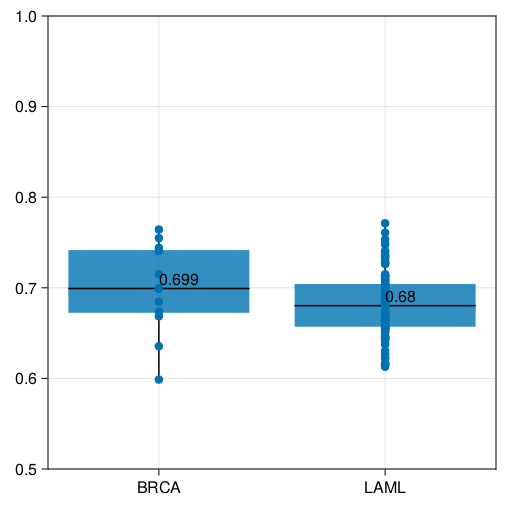

In [53]:
cphdnn = df[df[:,"model_type"] .== "cphdnn_v5",:]
cphdnn[cphdnn.dataset .!= "BRCA", "dataset"] .= "LAML"
#combine(groupby(cphdnn[:,["dataset", "cph_tst_c_ind"]], :dataset), :cph_tst_c_ind=>median) 
sorted_df = sort(cphdnn, :dataset)
sorted_df = leftjoin(sorted_df, DataFrame(:id =>collect(1:length(unique(sorted_df.dataset))), :dataset =>unique(sorted_df.dataset)), on = :dataset)

fig =  Figure(resolution = (512,512));
ax = Axis(fig[1,1],
    xticks = (collect(1:length(unique(sorted_df.dataset))), unique(sorted_df.dataset)), 
    limits = (nothing, nothing, 0.5, 1))
boxplot!(ax, sorted_df.id, sorted_df[:,"cph_tst_c_ind"])
scatter!(ax, sorted_df[:,"id"], sorted_df[:,"cph_tst_c_ind"])
medians = combine(groupby(sorted_df[:,["id", "cph_tst_c_ind"]], :id), :cph_tst_c_ind=>median) 
text!(ax, medians.id, medians.cph_tst_c_ind_median, text= string.(round.(medians.cph_tst_c_ind_median, digits = 3)))

fig

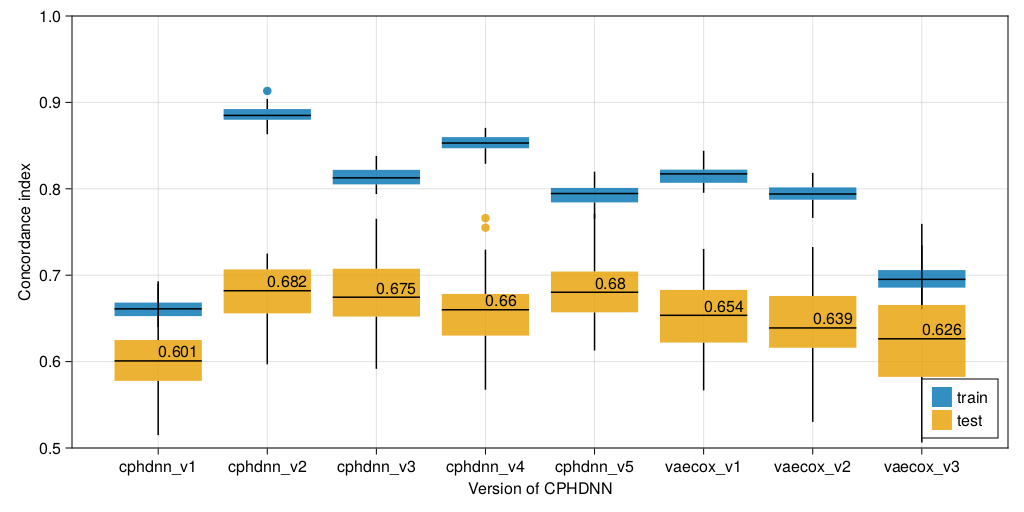

In [11]:
sorted_df = sort(df, :model_type)
sorted_df = leftjoin(sorted_df, DataFrame(:id =>collect(1:length(unique(sorted_df.model_type))), :model_type =>unique(sorted_df.model_type)), on = :model_type)

fig = Figure(resolution = (1024,512));
ax = Axis(fig[1,1],
    ylabel = "Concordance index", 
    xlabel = "Version of CPHDNN",
    limits = (nothing, nothing, 0.5, 1),
    xticks = (collect(1:length(unique(sorted_df.model_type))), unique(sorted_df.model_type)))#(log2.(unique(V1[:, "dim_redux"])), ["$x" for x in unique(V1_2[:, "dim_redux"])] ));
boxplot!(ax, sorted_df.id, sorted_df[:,"cph_train_c_ind"], label = "train")
boxplot!(ax, sorted_df.id, sorted_df[:,"cph_tst_c_ind"], label = "test")
medians = combine(groupby(sorted_df[:,["id", "cph_tst_c_ind"]], :id), :cph_tst_c_ind=>median) 
text!(ax, medians.id, medians.cph_tst_c_ind_median, text= string.(round.(medians.cph_tst_c_ind_median, digits = 3)))
#scatter!(ax, , V1[:,"cph_tst_c_ind"], label = "test")
axislegend(ax,position =:rb)
fig

In [10]:
medians = combine(groupby(sorted_df[:,["id", "cph_tst_c_ind"]], :id), :cph_tst_c_ind=>median) 
string.(round.(medians.cph_tst_c_ind_median, digits = 3))

7-element Vector{String}:
 "0.601"
 "0.682"
 "0.675"
 "0.66"
 "0.68"
 "0.654"
 "0.639"

In [13]:
median(df[df.model_type .== "vaecox_v2","cph_tst_c_ind"])
sorted_df[sorted_df.model_type .== "vaecox_v2",:]

,ae_lr,dim_redux,ae_nb_hls,nsamples,cph_wd,cph_hl_size,nepochs,venc_nb_hl
,Float64,Int64,Int64,Int64,Float64,Int64,Int64,Int64
1,1.0e-6,125,2,300,0.0001,64,10000,2
2,1.0e-6,125,2,300,0.0001,64,10000,2
3,1.0e-6,125,2,300,0.0001,64,10000,2
4,1.0e-6,125,2,300,0.0001,64,10000,2
5,1.0e-6,125,2,300,0.0001,64,10000,2
6,1.0e-6,125,2,300,0.0001,64,10000,2
7,1.0e-6,125,2,300,0.0001,64,10000,2
8,1.0e-6,125,2,300,0.0001,64,10000,2
9,1.0e-6,125,2,300,0.0001,64,10000,2


In [322]:
means = combine(groupby(sorted_df[:,["id", "cph_tst_c_ind"]], :id), :cph_tst_c_ind=>mean) 

,id,cph_tst_c_ind_mean
,Int64?,Float64
1,1,0.595233
2,2,0.669938
3,3,0.678311
4,4,0.656278
5,5,0.678584
6,6,0.650901


In [324]:
means.id

6-element Vector{Union{Missing, Int64}}:
 1
 2
 3
 4
 5
 6